In [1]:
import os

cwd = os.getcwd()
DATADIR = "C:\\Users\\degas\\Desktop\\Thesis\\datasets\\roco-dataset\\data\\train\\radiology\\images\\**" 
VALLOSSDIR = "C:\\Users\\degas\\Desktop\\Thesis\\notebooks\\shared weights\\MMBERT ROCO pretrain weights\\rocopretrain_weights.pt"
#print(DATADIR)
#os.listdir(DATADIR)

#os.mkdir('/kaggle/working/roco-weights')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
#print(os.listdir('../input/sample/images'))

In [2]:
multipleImages = glob('C:\\Users\\degas\\Desktop\\Thesis\\datasets\\roco-dataset\\data\\train\\radiology\\images\\**')
def plotImages2():
    r = random.sample(multipleImages, 9)
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(332)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(333)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(334)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')
    plt.subplot(335)
    plt.imshow(cv2.imread(r[4])); plt.axis('off')
    plt.subplot(336)
    plt.imshow(cv2.imread(r[5])); plt.axis('off')
    plt.subplot(337)
    plt.imshow(cv2.imread(r[6])); plt.axis('off')
    plt.subplot(338)
    plt.imshow(cv2.imread(r[7])); plt.axis('off')
    plt.subplot(339)
    plt.imshow(cv2.imread(r[8])); plt.axis('off')

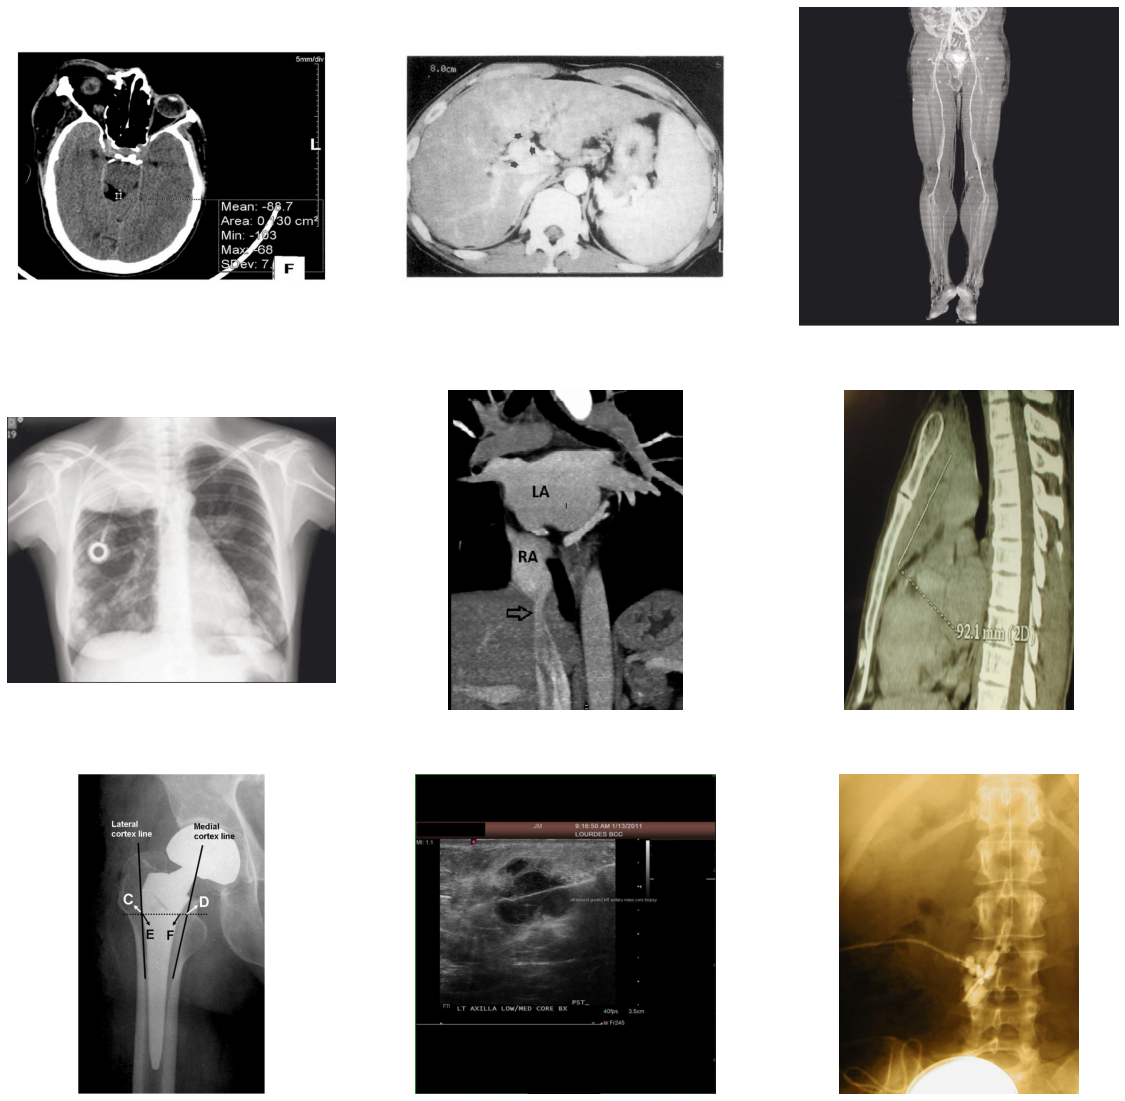

In [3]:
plotImages2()

# Utils ROCO

In [4]:
import os
import numpy as np
import pandas as pd
import math
import torch
import random
import wandb
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import pickle

import pytorch_lightning as pl

import torch
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_permutation(n):
    index_list = list(np.arange(n))
    perms = []
    for i in range(n):
        lst = index_list[:i] + index_list[i+1:]
        perms.append(np.random.choice(lst))
    return perms

def get_keywords(args):
    with open(os.path.join(args.data_dir, 'vocab', 'med_vocab.pkl'), 'rb') as f:
        key = pickle.load(f)

    keywords = []

    for k,v in key.items():
        keywords.extend(v)
    
    keywords_ = list(set(keywords))

    for word in keywords_:
        keywords.extend(word + '.')
    
    keywords = list(set(keywords))

    return keywords

In [7]:
def load_mlm_data(args):
    train_path = os.path.join(args.data_dir,'train','radiology')
    val_path = os.path.join(args.data_dir,'validation','radiology')
    test_path = os.path.join(args.data_dir,'test','radiology')

    train_data = pd.read_csv(os.path.join(train_path,'traindata_fix.csv'))
    val_data = pd.read_csv(os.path.join(val_path, 'valdata_fix.csv'))
    test_data = pd.read_csv(os.path.join(test_path, 'testdata_fix.csv'))
    
    train_data = train_data.sample(frac = args.train_pct)
    val_data = val_data.sample(frac = args.valid_pct)
    test_data = test_data.sample(frac = args.test_pct)
        
    return train_data, val_data, test_data

In [8]:
def shuffle_list(some_list):
    length = len(some_list)
    for i in range(length):
        j = i + np.floor(np.random.uniform()*(length - i - 1))
        j = int(j)
        some_list[i], some_list[j] = some_list[j], some_list[i]

    return some_list

def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def mask_word(sentence, tokenizer, args): #, keywords
    tokens = sentence.split()
    output_label = []
    new_tokens = []

    for i, char in enumerate(tokens):
        #if char in keywords:
        t = tokenizer.tokenize(char)
        for j in range(len(t)):
            prob = random.random()
            if prob < args.mlm_prob:
                
                output_label.extend([tokenizer.encode(t[j])[1]])
                t[j] = '[MASK]'

            else:
                output_label.extend([0])
        new_tokens.extend(t)
        #else:
        #t = tokenizer.tokenize(char)
        #new_tokens.extend(t)
        #output_label.extend([0]*len(t))
            
    assert (len(new_tokens)==len(output_label)), "Token len must be equal to label len"
    #print("final new_tokens: ")
    #print(new_tokens)
    #print("final output_label: ")
    #print(output_label)
    return  new_tokens, output_label

In [9]:
def encode_text(caption,tokenizer, args): #, keywords
    part1 = [0 for _ in range(5)]
    #get token ids and remove [CLS] and [SEP] token id
    caption, labels = mask_word(caption, tokenizer, args) #, keywords

    
    part2 = tokenizer.convert_tokens_to_ids(caption)
    part2 = part2[:args.max_position_embeddings-8]
    labels = labels[:args.max_position_embeddings-8]
    
    tokens = [tokenizer.cls_token_id] + part1 + [tokenizer.sep_token_id] + part2 + [tokenizer.sep_token_id]
    labels = [0]*(2+len(part1)) + labels + [0]
    
    segment_ids = [0]*(len(part1)+2) + [1]*(len(part2[:args.max_position_embeddings-8])+1)
    input_mask = [1]*len(tokens)
    n_pad = args.max_position_embeddings - len(tokens)
    tokens.extend([0]*n_pad)
    segment_ids.extend([0]*n_pad)
    input_mask.extend([0]*n_pad)
    labels.extend([0]*(n_pad))

    
    return torch.tensor(tokens,dtype=torch.long), torch.tensor(segment_ids,dtype=torch.long), torch.tensor(input_mask,dtype=torch.long), torch.tensor(labels)


In [10]:
def calculate_bleu_score(preds,targets):
  bleu_per_answer = np.asarray([sentence_bleu([idx2ans[target].split()],idx2ans[pred].split()) for pred,target in zip(preds,targets)])

In [11]:
def train_one_epoch(loader, model, criterion, optimizer, scaler, device, args, epoch):

    model.train()
    train_loss = []
    PREDS = []
    TARGETS = []
    bar = tqdm(loader, leave = False)
    #print("prima di for")
    #enumerate(bar)
    for i, (img, caption_token,segment_ids,attention_mask,target) in enumerate(bar):
        #print("entrato in for")
        img, caption_token,segment_ids,attention_mask,target = img.to(device), caption_token.to(device), segment_ids.to(device), attention_mask.to(device), target.to(device)
        caption_token = caption_token.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
    
        loss_func = criterion
        optimizer.zero_grad()
        #print("prima di model()")
        if args.mixed_precision:
            with torch.cuda.amp.autocast():
                logits = model(img, caption_token, segment_ids, attention_mask)
                logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
                loss = loss_func(logits.permute(0,2,1), target)
        else:
            logits = model(img, caption_token, segment_ids, attention_mask)
            logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
            loss = loss_func(logits.permute(0,2,1), target)       


        if args.mixed_precision:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()    

        # logits = model(img, caption_token, segment_ids, attention_mask)
        # logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
        # loss = loss_func(logits.permute(0,2,1), target)

        # loss.backward()
        # optimizer.step()       
        
        bool_label = target > 0

        pred = logits[bool_label, :].argmax(1)
        valid_labels = target[bool_label]   
        
        PREDS.append(pred)
        TARGETS.append(valid_labels)
        
        loss_np = loss.detach().cpu().numpy()
        acc = (pred == valid_labels).type(torch.float).mean() * 100.
        train_loss.append(loss_np)
        bar.set_description('train_loss: %.5f, train_acc: %.2f' % (loss_np, acc))

        """wandb.log({'step_train_loss': loss_np,
            'step_train_acc': acc,
            'train_batch': epoch*len(loader) + i})"""
        

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()

#     # Calculate total accuracy
    total_acc = (PREDS == TARGETS).mean() * 100.

    return np.mean(train_loss), total_acc

In [12]:
def validate(loader, model, criterion, scaler, device, args, epoch):

    model.eval()
    val_loss = []

    PREDS = []
    TARGETS = []
    bar = tqdm(loader, leave=False)

    with torch.no_grad():
        for i, (img, caption_token,segment_ids,attention_mask,target) in enumerate(bar):

            img, caption_token,segment_ids,attention_mask,target = img.to(device), caption_token.to(device), segment_ids.to(device), attention_mask.to(device), target.to(device)
            caption_token = caption_token.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            
            loss_func = criterion

            if args.mixed_precision:
                with torch.cuda.amp.autocast():
                    logits = model(img, caption_token, segment_ids, attention_mask)
                    logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
                    loss = loss_func(logits.permute(0,2,1), target)
            else:
                logits = model(img, caption_token, segment_ids, attention_mask)
                logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
                loss = loss_func(logits.permute(0,2,1), target)       


            # logits = model(img, caption_token, segment_ids, attention_mask)
            # logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
            # loss = loss_func(logits.permute(0,2,1), target)

            bool_label = target > 0
            pred = logits[bool_label, :].argmax(1)
            valid_labels = target[bool_label]   
        
            PREDS.append(pred)
            TARGETS.append(valid_labels)
            
            loss_np = loss.detach().cpu().numpy()

            val_loss.append(loss_np)

            acc = (pred == valid_labels).type(torch.float).mean() * 100.

            bar.set_description('val_loss: %.5f, val_acc: %.5f' % (loss_np, acc))

            """wandb.log({'step_val_loss': loss_np,
                'step_val_acc': acc,
                'val_batch': epoch*len(loader) + i})"""

        val_loss = np.mean(val_loss)

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()

    # Calculate total accuracy
    total_acc = (PREDS == TARGETS).mean() * 100.


    return val_loss, PREDS, total_acc

In [13]:
def test(loader):

    model.eval()

    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (img,caption_token,attention_mask,target) in tqdm(loader, leave=False):

            img, caption_token,segment_ids,attention_mask,target = img.to(device), caption_token.to(device), segment_ids.to(device), attention_mask.to(device), target.to(device)
            caption_token = caption_token.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            
            logits = model(img, caption_token, segment_ids, attention_mask)
        
            bool_label = target > 0
            pred = logits[bool_label, :].argmax(1)
            valid_labels = target[bool_label]   
        
            PREDS.append(pred)
            TARGETS.append(valid_labels)

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()

    total_acc = (PREDS == TARGETS).mean() * 100.

    return PREDS, total_acc

In [14]:
class ROCO(Dataset):
    def __init__(self, args, df, tfm, mode):
        self.df = df.values
        self.args = args
        self.path = args.data_dir
        self.tfm = tfm
        #self.keys = keys
        self.mode = mode
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        name = self.df[idx,0]              
        path = os.path.join(self.path, self.mode, 'radiology', 'images',name)
        #print("name: " ,name)

        img = Image.open(path).convert('RGB')
        
        if self.tfm:
            img = self.tfm(img)
    
        caption = self.df[idx, 1].strip()
    
        
        tokens, segment_ids, input_mask, targets = encode_text(caption, self.tokenizer, self.args) #, self.keys

        
        return img, tokens, segment_ids, input_mask, targets

In [15]:
class ROCOModule(pl.LightningDataModule):
    def __init__(self, args):
        super(ROCOModule, self).__init__()

        self.args = args

    def setup(self, stage=None):

        train, val, test = load_mlm_data(self.args)

        train = train[train['name']!='PMC4240561_MA-68-291-g002.jpg'].reset_index(drop=True)

        train_tfm = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.RandomResizedCrop(224,scale=(0.95,1.05),ratio=(0.95,1.05)),
                                    transforms.RandomRotation(5),
                                    transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        val_tfm = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.train = ROCO(self.args, train, train_tfm, 'train')
        self.val = ROCO(self.args, val, val_tfm, 'validation')
        self.test = ROCO(self.args, test, val_tfm, 'test')

    def train_dataloader(self):
        return DataLoader(self.train, batch_size = self.args.batch_size, shuffle = True, num_workers = self.args.num_workers, pin_memory = True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size = self.args.batch_size, shuffle = False, num_workers = self.args.num_workers, pin_memory = True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size = self.args.batch_size, shuffle = False, num_workers = self.args.num_workers, pin_memory = True)

In [16]:
class ROCOModel(pl.LightningModule):
    def __init__(self, args, model):
        super(ROCOModel,self).__init__()

        self.args = args
        self.model = model

    def training_step(self, batch, batch_idx):

        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.TrainResult(loss)

        container = {'train_loss': loss, 'train_acc': acc}

        result.log_dict(container, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return result

    def validation_step(self, batch, batch_idx):

        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on = loss)

        container = {'val_loss': loss, 'val_acc': acc}        
        result.log_dict(container, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return result

    def shared_step(self, batch, batch_idx):

        img, caption_token, segment_ids, attention_mask, target = batch
        caption_token = caption_token.squeeze(1)
        attention_mask = attention_mask.squeeze(1)

        logits = self.model(img, caption_token, segment_ids, attention_mask)
        
        bool_label = target > 0
        pred = logits[bool_label, :].argmax(1)
        valid_labels = target[bool_label]  

        logits = logits.log_softmax(-1)  # (bs x seq_len x vocab_size)
        
        loss = self.loss_func(logits.permute(0,2,1), target)
        acc = (pred == valid_labels).type(torch.float).mean() * 100.

        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr = self.args.lr)

        return [optimizer]

    def loss_func(self, pred, target):
        return nn.NLLLoss()(pred, target)

In [17]:
class Embeddings(nn.Module):
    def __init__(self, args):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(args.vocab_size, 128, padding_idx=0)
        self.word_embeddings_2 = nn.Linear(128, args.hidden_size, bias=False)
        self.position_embeddings = nn.Embedding(args.max_position_embeddings, args.hidden_size)
        self.type_embeddings = nn.Embedding(3, args.hidden_size)
        self.LayerNorm = nn.LayerNorm(args.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)
        self.len = args.max_position_embeddings
    def forward(self, input_ids, segment_ids, position_ids=None):
        if position_ids is None:
            if torch.cuda.is_available():
                position_ids = torch.arange(self.len, dtype=torch.long).cuda()
            else:
                position_ids = torch.arange(self.len, dtype=torch.long)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        words_embeddings = self.word_embeddings(input_ids)
        words_embeddings = self.word_embeddings_2(words_embeddings)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.type_embeddings(segment_ids)
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [18]:
class Transfer(nn.Module):
    def __init__(self,args):
        super(Transfer, self).__init__()

        self.args = args
        self.model = models.resnet152(pretrained=True)
        # for p in self.parameters():
        #     p.requires_grad=False
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(2048, args.hidden_size, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.gap2 = nn.AdaptiveAvgPool2d((1,1))
        self.conv3 = nn.Conv2d(1024, args.hidden_size, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.gap3 = nn.AdaptiveAvgPool2d((1,1))
        self.conv4 = nn.Conv2d(512, args.hidden_size, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.gap4 = nn.AdaptiveAvgPool2d((1,1))
        self.conv5 = nn.Conv2d(256, args.hidden_size, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.gap5 = nn.AdaptiveAvgPool2d((1,1))
        self.conv7 = nn.Conv2d(64, args.hidden_size, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.gap7 = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, img):
        modules2 = list(self.model.children())[:-2]
        fix2 = nn.Sequential(*modules2)
        v_2 = self.gap2(self.relu(self.conv2(fix2(img)))).view(-1,self.args.hidden_size)
        modules3 = list(self.model.children())[:-3]
        fix3 = nn.Sequential(*modules3)
        v_3 = self.gap3(self.relu(self.conv3(fix3(img)))).view(-1,self.args.hidden_size)
        modules4 = list(self.model.children())[:-4]
        fix4 = nn.Sequential(*modules4)
        v_4 = self.gap4(self.relu(self.conv4(fix4(img)))).view(-1,self.args.hidden_size)
        modules5 = list(self.model.children())[:-5]
        fix5 = nn.Sequential(*modules5)
        v_5 = self.gap5(self.relu(self.conv5(fix5(img)))).view(-1,self.args.hidden_size)
        modules7 = list(self.model.children())[:-7]
        fix7 = nn.Sequential(*modules7)
        v_7 = self.gap7(self.relu(self.conv7(fix7(img)))).view(-1,self.args.hidden_size)
        return v_2, v_3, v_4, v_5, v_7

In [19]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self,args):
        super(MultiHeadedSelfAttention,self).__init__()
        self.proj_q = nn.Linear(args.hidden_size, args.hidden_size)
        self.proj_k = nn.Linear(args.hidden_size, args.hidden_size)
        self.proj_v = nn.Linear(args.hidden_size, args.hidden_size)
        self.drop = nn.Dropout(args.hidden_dropout_prob)
        self.scores = None
        self.n_heads = args.heads
    def forward(self, x, mask):
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        q, k, v = (self.split_last(x, (self.n_heads, -1)).transpose(1, 2) for x in [q, k, v])
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1))
        if mask is not None:
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        h = (scores @ v).transpose(1, 2).contiguous()
        h = self.merge_last(h, 2)
        self.scores = scores
        return h
    def split_last(self, x, shape):
        shape = list(shape)
        assert shape.count(-1) <= 1
        if -1 in shape:
            shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
        return x.view(*x.size()[:-1], *shape)
    def merge_last(self, x, n_dims):
        s = x.size()
        assert n_dims > 1 and n_dims < len(s)
        return x.view(*s[:-n_dims], -1)

In [20]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self,args):
        super(PositionWiseFeedForward,self).__init__()
        self.fc1 = nn.Linear(args.hidden_size, args.hidden_size*4)
        self.fc2 = nn.Linear(args.hidden_size*4, args.hidden_size)
    def forward(self, x):
        return self.fc2(gelu(self.fc1(x)))

In [21]:
class BertLayer(nn.Module):
    def __init__(self,args, share='all', norm='pre'):
        super(BertLayer, self).__init__()
        self.share = share
        self.norm_pos = norm
        self.norm1 = nn.LayerNorm(args.hidden_size, eps=1e-12)
        self.norm2 = nn.LayerNorm(args.hidden_size, eps=1e-12)
        self.drop1 = nn.Dropout(args.hidden_dropout_prob)
        self.drop2 = nn.Dropout(args.hidden_dropout_prob)
        if self.share == 'ffn':
            self.attention = nn.ModuleList([MultiHeadedSelfAttention(args) for _ in range(args.n_layers)])
            self.proj = nn.ModuleList([nn.Linear(args.hidden_size, args.hidden_size) for _ in range(args.n_layers)])
            self.feedforward = PositionWiseFeedForward(args)
        elif self.share == 'att':
            self.attention = MultiHeadedSelfAttention(args)
            self.proj = nn.Linear(args.hidden_size, args.hidden_size)
            self.feedforward = nn.ModuleList([PositionWiseFeedForward(args) for _ in range(args.n_layers)])
        elif self.share == 'all':
            self.attention = MultiHeadedSelfAttention(args)
            self.proj = nn.Linear(args.hidden_size, args.hidden_size)
            self.feedforward = PositionWiseFeedForward(args)
        elif self.share == 'none':
            self.attention = nn.ModuleList([MultiHeadedSelfAttention(args) for _ in range(args.n_layers)])
            self.proj = nn.ModuleList([nn.Linear(args.hidden_size, args.hidden_size) for _ in range(args.n_layers)])
            self.feedforward = nn.ModuleList([PositionWiseFeedForward(args) for _ in range(args.n_layers)])
    def forward(self, hidden_states, attention_mask, layer_num):
        if self.norm_pos == 'pre':
            if isinstance(self.attention, nn.ModuleList):
                h = self.proj[layer_num](self.attention[layer_num](self.norm1(hidden_states), attention_mask))
            else:
                h = self.proj(self.attention(self.norm1(hidden_states), attention_mask))
            out = hidden_states + self.drop1(h)
            if isinstance(self.feedforward, nn.ModuleList):
                h = self.feedforward[layer_num](self.norm1(out))
            else:
                h = self.feedforward(self.norm1(out))
            out = out + self.drop2(h)
        if self.norm_pos == 'post':
            if isinstance(self.attention, nn.ModuleList):
                h = self.proj[layer_num](self.attention[layer_num](hidden_states, attention_mask))
            else:
                h = self.proj(self.attention(hidden_states, attention_mask))
            out = self.norm1(hidden_states + self.drop1(h))
            if isinstance(self.feedforward, nn.ModuleList):
                h = self.feedforward[layer_num](out)
            else:
                h = self.feedforward(out)
            out = self.norm2(out + self.drop2(h))
        return out

In [22]:
class Transformer(nn.Module):
    def __init__(self, args):
        super(Transformer,self).__init__()
        base_model = BertModel.from_pretrained('bert-base-uncased')
        bert_model = nn.Sequential(*list(base_model.children())[0:])
        self.bert_embedding = bert_model[0]
#         self.embed = Embeddings(args)
        self.trans = Transfer(args)
        self.blocks = BertLayer(args,share='none', norm='pre')
        self.n_layers = args.n_layers
    def forward(self, img, input_ids, token_type_ids, mask):
        v_2, v_3, v_4, v_5, v_7 = self.trans(img)
#         h = self.embed(input_ids, token_type_ids)
        h = self.bert_embedding(input_ids=input_ids, token_type_ids=token_type_ids, position_ids=None)
        for i in range(len(h)):
            h[i][1] = v_2[i]
        for i in range(len(h)):
            h[i][2] = v_3[i]
        for i in range(len(h)):
            h[i][3] = v_4[i]
        for i in range(len(h)):
            h[i][4] = v_5[i]
        for i in range(len(h)):
            h[i][5] = v_7[i]
        for i in range(self.n_layers):
            h = self.blocks(h, mask, i)
        return h

In [23]:
class Model(nn.Module):
    def __init__(self,args):
        super(Model,self).__init__()
        self.transformer = Transformer(args)
        self.fc1 = nn.Linear(args.hidden_size, args.hidden_size)
        self.activ1 = nn.Tanh()
        self.classifier = nn.Sequential(nn.Linear(args.hidden_size, args.hidden_size),
                                        nn.LayerNorm(args.hidden_size, eps=1e-12, elementwise_affine=True),
                                        nn.Linear(args.hidden_size, args.vocab_size))
    def forward(self, img, input_ids, segment_ids, input_mask):
        h = self.transformer(img, input_ids, segment_ids, input_mask)
        pooled_h = self.activ1(self.fc1(h))
        logits = self.classifier(pooled_h)
        return logits

# Train ROCO

In [24]:
import os
import wandb
import argparse
import numpy as np
import sys
import pandas as pd

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import optim
from torch.optim import lr_scheduler

In [25]:
sys.argv = ['-f']

parser = argparse.ArgumentParser(description="Pretrain on ROCO with MLM")

parser.add_argument('--run_name', type=str, required=False, default = 'kaggle roco mlm 0.15' ,help="name for wandb run", )
parser.add_argument('--data_dir', type=str, default = 'C:\\Users\\degas\\Desktop\\Thesis\\datasets\\roco-dataset\\data', help='path to dataset', required = False)
parser.add_argument('--save_dir', type=str, default = 'C:\\Users\\degas\\Desktop\\Thesis\\notebooks\\MMBERT pretrain\\new mmbert pretrain weights', help='save model weights in this dir', required = False)
parser.add_argument('--mlm_prob', type=float, default=0.15, help='probability of token being masked') #0.05
parser.add_argument('--mixed_precision', action='store_true', required = False, default = False,  help='mixed precision training or not')
parser.add_argument('--resume', action='store_true', required = False, default = True,  help='resume training or train from scratch')

parser.add_argument('--batch_size', type=int, default=2, help='batch_size.')
parser.add_argument('--lr', type=float, default=2e-5, help='learning rate')
parser.add_argument('--patience', type=int, default=5, help='rlp patience')
parser.add_argument('--factor', type=float, default=0.1, help='rlp factor')
parser.add_argument('--num_workers', type=int, default=1, help='num works to generate data.') #default=4
parser.add_argument('--epochs', type=int, default=40, help='epochs to train')

parser.add_argument('--train_pct', type=float, default=1.0, help='fraction of train set')
parser.add_argument('--valid_pct', type=float, default=1.0, help='fraction of validation set')
parser.add_argument('--test_pct', type=float, default=1.0, help='fraction of test set ')

parser.add_argument('--max_position_embeddings', type=int, default=75, help='embedding size')
parser.add_argument('--n_layers', type=int, default=4, help='num of heads in multihead attenion')
parser.add_argument('--heads', type=int, default=12, help='num of bertlayers')
parser.add_argument('--type_vocab_size', type=int, default=2, help='types of tokens ')
parser.add_argument('--vocab_size', type=int, default=30522, help='vocabulary size')
parser.add_argument('--hidden_size', type=int, default=768, help='embedding size')
parser.add_argument('--hidden_dropout_prob', type=float, default=0.3, help='dropout')


args = parser.parse_args()

In [26]:
wandb.init(project='medvqa', name = args.run_name, config = args)

wandb: Currently logged in as: kaidegast (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [27]:
train_data, val_data, test_data  = load_mlm_data(args)
# No Image: PMC4240561_MA-68-291-g002.jpg
#train_data = train_data[train_data['name']!='PMC4240561_MA-68-291-g002.jpg'].reset_index(drop=True)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Model(args)

model.to(device)

#wandb.watch(model, log='all')

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (transformer): Transformer(
    (bert_embedding): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (trans): Transfer(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, 

In [29]:
#model.load_state_dict(torch.load(VALLOSSDIR))

In [30]:
display(train_data)

,name,caption
65219,PMC2994178_ASM-30-497-g004.jpg,photograph shows straight x-ray of abdomen wit...
43777,PMC3915732_pghn-16-269-g001.jpg,abdominal ultrasonography shows pseudo-kidney ...
38880,PMC3099119_JCD-14-68-g009.jpg,group b post operative radiograph at 1 month f...
22034,PMC2967700_wjem11_4p400f1.jpg,abdominal radiograph
42691,PMC4716447_rjv17202.jpg,plate and dall-miles cable fixation of peripro...
...,...,...
19310,PMC4725614_cureus-0007-000000000401-i01.jpg,axial t2-weighted mri of the thoracic spine de...
31079,PMC5400202_10.1177_2325967117702361-fig3.jpg,ultrasound imaging of the ulnohumeral joint . ...
42088,PMC4310892_CEJU-67-00433-g003.jpg,scrotal ultrasound of 56 year old veteran four...
61825,PMC3883470_1752-1947-7-285-2.jpg,transesophageal echocardiogram . transesophage...


In [31]:
"""train_img_path = os.path.join(args.data_dir,'train/radiology/images')
val_img_path = os.path.join(args.data_dir,'validation/radiology/images')
test_img_path = os.path.join(args.data_dir,'test/radiology/images')

print("check train")
toremove = []
for index, row in train_data.iterrows():
  name = row[0]
  cap = row[1]

  image_path = os.path.join(train_img_path, name)
  if os.path.isfile(image_path) == False:
    print("image " + name + " not found")
    toremove.append(index)

print("to be removed: " ,toremove)
train_data = train_data.drop(index = toremove)"""

'train_img_path = os.path.join(args.data_dir,\'train/radiology/images\')\nval_img_path = os.path.join(args.data_dir,\'validation/radiology/images\')\ntest_img_path = os.path.join(args.data_dir,\'test/radiology/images\')\n\nprint("check train")\ntoremove = []\nfor index, row in train_data.iterrows():\n  name = row[0]\n  cap = row[1]\n\n  image_path = os.path.join(train_img_path, name)\n  if os.path.isfile(image_path) == False:\n    print("image " + name + " not found")\n    toremove.append(index)\n\nprint("to be removed: " ,toremove)\ntrain_data = train_data.drop(index = toremove)'

In [32]:
"""train_data.reset_index(drop=True, inplace=True)
display(train_data)"""

'train_data.reset_index(drop=True, inplace=True)\ndisplay(train_data)'

In [33]:
"""name="PMC4240561_MA-68-291-g002.jpg"
image_path = os.path.join(train_img_path, name)
print(image_path)
img = Image.open(image_path).convert('RGB')

plt.imshow(img)

print(train_data[train_data['name']=='PMC4240561_MA-68-291-g002.jpg'])"""

'name="PMC4240561_MA-68-291-g002.jpg"\nimage_path = os.path.join(train_img_path, name)\nprint(image_path)\nimg = Image.open(image_path).convert(\'RGB\')\n\nplt.imshow(img)\n\nprint(train_data[train_data[\'name\']==\'PMC4240561_MA-68-291-g002.jpg\'])'

In [34]:
"""print(val_data.shape)
print("check valid")
toremove = []
found = 0
not_found = 0
for index, row in val_data.iterrows():
    name = row[0]
    cap = row[1]
    
    image_path = os.path.join(val_img_path, name)
    if os.path.isfile(image_path) == False:
        print("image " + name + " not found")
        toremove.append(index)
    else:
        found = found + 1

print("found: " ,found)
if toremove:
    print("to be removed: " ,toremove)
    valid_data = valid_data.drop(index = toremove)
    valid_data.reset_index(drop=True, inplace=True)"""

'print(val_data.shape)\nprint("check valid")\ntoremove = []\nfound = 0\nnot_found = 0\nfor index, row in val_data.iterrows():\n    name = row[0]\n    cap = row[1]\n    \n    image_path = os.path.join(val_img_path, name)\n    if os.path.isfile(image_path) == False:\n        print("image " + name + " not found")\n        toremove.append(index)\n    else:\n        found = found + 1\n\nprint("found: " ,found)\nif toremove:\n    print("to be removed: " ,toremove)\n    valid_data = valid_data.drop(index = toremove)\n    valid_data.reset_index(drop=True, inplace=True)'

In [35]:
"""print(test_data.shape)
print("check test")
toremove = []
found = 0
not_found = 0
for index, row in test_data.iterrows():
    name = row[0]
    cap = row[1]
    
    image_path = os.path.join(test_img_path, name)
    if os.path.isfile(image_path) == False:
        print("image " + name + " not found")
        toremove.append(index)
    else:
        found = found + 1

print("found: " ,found)
if toremove:
    print("to be removed: " ,toremove)
    test_data = test_data.drop(index = toremove)
    test_data.reset_index(drop=True, inplace=True)"""

'print(test_data.shape)\nprint("check test")\ntoremove = []\nfound = 0\nnot_found = 0\nfor index, row in test_data.iterrows():\n    name = row[0]\n    cap = row[1]\n    \n    image_path = os.path.join(test_img_path, name)\n    if os.path.isfile(image_path) == False:\n        print("image " + name + " not found")\n        toremove.append(index)\n    else:\n        found = found + 1\n\nprint("found: " ,found)\nif toremove:\n    print("to be removed: " ,toremove)\n    test_data = test_data.drop(index = toremove)\n    test_data.reset_index(drop=True, inplace=True)'

In [36]:
#img = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
#input_ids = 
#segment_ids = 
#input_mask = 
#out = resnet(img, input_ids, segment_ids, input_mask)
#make_dot(out)

In [37]:
optimizer = optim.Adam(model.parameters(),lr=args.lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience = args.patience, factor = args.factor, verbose = True)
criterion = nn.NLLLoss()

In [38]:
train_tfm = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.RandomResizedCrop(224,scale=(0.95,1.05),ratio=(0.95,1.05)),
                                transforms.RandomRotation(5),
                                transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_tfm = transforms.Compose([transforms.Resize((224,224)), 
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [39]:
train_path = os.path.join(args.data_dir,'train')
val_path = os.path.join(args.data_dir,'validation')
test_path = os.path.join(args.data_dir,'test')

#keywords = get_keywords(args)    

traindataset = ROCO(args, train_data, train_tfm, mode='train')
valdataset = ROCO(args, val_data, val_tfm, mode = 'validation')

trainloader = DataLoader(traindataset, batch_size = args.batch_size, shuffle=True) #, num_workers = args.num_workers
valloader = DataLoader(valdataset, batch_size = args.batch_size, shuffle=False) #, num_workers = args.num_workers

scaler = GradScaler()

In [40]:
#next(iter(trainloader))

In [41]:
if args.resume:
    print("loading model to resume training")
    ckpt = torch.load('C:\\Users\\degas\\Desktop\\Thesis\\notebooks\\shared weights\\MMBERT pretrain mlm 015\\recorder_2.pt')
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    scheduler.load_state_dict(ckpt['scheduler'])
    scaler.load_state_dict(ckpt['scaler'])

if args.resume:
    best_loss = scheduler.best
else:
    best_loss = np.inf

save_recorder = 1

loading model to resume training


In [42]:
train_data.head()

,name,caption
65219,PMC2994178_ASM-30-497-g004.jpg,photograph shows straight x-ray of abdomen wit...
43777,PMC3915732_pghn-16-269-g001.jpg,abdominal ultrasonography shows pseudo-kidney ...
38880,PMC3099119_JCD-14-68-g009.jpg,group b post operative radiograph at 1 month f...
22034,PMC2967700_wjem11_4p400f1.jpg,abdominal radiograph
42691,PMC4716447_rjv17202.jpg,plate and dall-miles cable fixation of peripro...


In [43]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [44]:
torch.cuda.device_count()

1

In [45]:
from datetime import datetime
now = datetime.now()

with open("C:\\Users\\degas\\Desktop\\Thesis\\notebooks\\shared weights\\MMBERT pretrain mlm 015\\kaggle roco mlm 0.15.txt") as input_txt:
    with open(os.path.join(args.save_dir,"kaggle roco mlm 0.15.txt"), "w") as f:
        for line in input_txt:
            f.write(line) 

f = open(os.path.join(args.save_dir,f'{args.run_name}.txt'), "a")
f.write("\n\n\nRoco Pretraining " + str(now))
f.close()

In [46]:
torch.cuda.memory_allocated(device=0)

3351373824

In [47]:
print(trainloader)

In [48]:
for epoch in range(args.epochs):
    
    print(f'Epoch {epoch+1}/{args.epochs}')

    train_loss, train_acc = train_one_epoch(trainloader, model, criterion, optimizer, scaler, device, args, epoch)
    val_loss, predictions, acc = validate(valloader, model, criterion, scaler, device, args, epoch)

    scheduler.step(val_loss)

    recorder = {'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'model': model.state_dict()}

    torch.save(recorder, os.path.join(args.save_dir,'recorder_2.pt'))
        
    f = open(os.path.join(args.save_dir,f'{args.run_name}.txt'), "a")
    f.write('\n\nepoch ' + str(epoch))
    f.write('\nepoch_train_loss: ' + str(train_loss) + ',')
    f.write('\nepoch_val_loss: ' + str(val_loss) + ',')
    f.write('\nepoch_train_acc: ' + str(train_acc) + ',')
    f.write('\nepoch_val_acc: ' + str(acc) + ',')
    f.write('\nlearning_rate: ' + str(optimizer.param_groups[0]["lr"]))

    content = f'Learning rate: {(optimizer.param_groups[0]["lr"]):.7f}, Train loss: {(train_loss):.4f}, Train acc: {(train_acc):.4f} ,Val loss: {(val_loss):.4f}, Val acc: {(acc):.4f}'
    print(content)
    
    if val_loss<best_loss:
        f.write('\nnew best val_loss')
        torch.save(model.state_dict(), os.path.join(args.save_dir,'rocopretrain_weights.pt'))
        best_loss=val_loss
        
    f.close()

Epoch 1/40


Learning rate: 0.0000200, Train loss: 0.1211, Train acc: 61.8998 ,Val loss: 0.1224, Val acc: 63.2151
Epoch 2/40


Learning rate: 0.0000200, Train loss: 0.1239, Train acc: 61.9385 ,Val loss: 0.1231, Val acc: 63.2971
Epoch 3/40


Learning rate: 0.0000200, Train loss: 0.1230, Train acc: 62.3134 ,Val loss: 0.1215, Val acc: 63.3563
Epoch 4/40


Learning rate: 0.0000200, Train loss: 0.1230, Train acc: 62.5660 ,Val loss: 0.1232, Val acc: 63.5339
Epoch 5/40


KeyboardInterrupt: 

In [ ]:
"""for epoch in range(args.epochs):
    
    print(f'Epoch {epoch+1}/{args.epochs}')

    train_loss, train_acc = train_one_epoch(trainloader, model, criterion, optimizer, scaler, device, args, epoch)
    val_loss, predictions, acc = validate(valloader, model, criterion, scaler, device, args, epoch)

    scheduler.step(val_loss)

    recorder = {'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'model': model.state_dict()}

    torch.save(recorder, 'recorder_2.pt')
        
    f = open(f'{args.run_name}.txt', "a")
    f.write('\n\nepoch ' + str(epoch))
    f.write('\nepoch_train_loss: ' + str(train_loss) + ',')
    f.write('\nepoch_val_loss: ' + str(val_loss) + ',')
    f.write('\nepoch_train_acc: ' + str(train_acc) + ',')
    f.write('\nepoch_val_acc: ' + str(acc) + ',')
    f.write('\nlearning_rate: ' + str(optimizer.param_groups[0]["lr"]))

    content = f'Learning rate: {(optimizer.param_groups[0]["lr"]):.7f}, Train loss: {(train_loss):.4f}, Train acc: {(train_acc):.4f} ,Val loss: {(val_loss):.4f}, Val acc: {(acc):.4f}'
    print(content)
    
    if val_loss<best_loss:
        f.write('\nnew best val_loss')
        torch.save(model.state_dict(), os.path.join(args.save_dir,'rocopretrain_weights.pt'))
        best_loss=val_loss
        
    f.close()"""

In [ ]:
"""for epoch in range(args.epochs):
    
    print(f'Epoch {epoch+1}/{args.epochs}')

    train_loss, train_acc = train_one_epoch(trainloader, model, criterion, optimizer, scaler, device, args, epoch)
    val_loss, predictions, acc = validate(valloader, model, criterion, scaler, device, args, epoch)

    scheduler.step(val_loss)

    if (epoch + 1) % save_recorder == 0:
        recorder = {'epoch': epoch,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'scaler': scaler.state_dict(),
                'model': model.state_dict()}

        torch.save(recorder, 'recorder_2.pt')
        

    wandb.log({'epoch_train_loss': train_loss,
            'epoch_val_loss': val_loss,
            'epoch_train_acc': train_acc,
            'epoch_val_acc': acc,
            'learning_rate': optimizer.param_groups[0]["lr"],
            'epoch': epoch})

    content = f'Learning rate: {(optimizer.param_groups[0]["lr"]):.7f}, Train loss: {(train_loss):.4f}, Train acc: {(train_acc):.4f} ,Val loss: {(val_loss):.4f}, Val acc: {(acc):.4f}'
    print(content)
    
    if val_loss<best_loss:
        torch.save(model.state_dict(), 'rocopretrain_weights.pt')
        best_loss=val_loss"""